In [1]:
import cv2
import numpy as np
import os
from IPython.display import Video, display

## Lane Detection Pipeline

In [2]:
#Edge Detection
def canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(blur, 50, 150)
    return edges

In [3]:
#ROI
def region_of_interest(image):
    h, w = image.shape[:2]

    polygon = np.array([[(0, h), (w, h), (w//2, int(h * 0.55))]])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygon, 255)
    return cv2.bitwise_and(image, mask)

In [4]:
#Extract and Average Hough lines
def average_slope_intercept(image, lines):
    if lines is None:
        return []

    left_fit = []
    right_fit = []

    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        slope, intercept = np.polyfit((x1, x2), (y1, y2), 1)

        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))

    final_lines = []

    if len(left_fit) > 0:
        avg_left = np.average(left_fit, axis=0)
        final_lines.append(make_coordinates(image, avg_left))

    if len(right_fit) > 0:
        avg_right = np.average(right_fit, axis=0)
        final_lines.append(make_coordinates(image, avg_right))

    return final_lines

In [5]:
#Slopes to Coordinates
def make_coordinates(image, line_params):
    slope, intercept = line_params
    y1 = image.shape[0]
    y2 = int(y1 * 0.6)

    if slope == 0:
        slope = 0.01

    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])

In [6]:
#Lines Display
def display_lines(image, lines):
    line_img = np.zeros_like(image)

    if lines is None or len(lines) == 0:
        return line_img

    for line in lines:
        if line is None:
            continue

        line = np.array(line).flatten()

        if len(line) != 4:
            continue

        x1, y1, x2, y2 = line

        try:
            cv2.line(line_img, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,0), 8)
        except:
            continue

    return line_img

In [7]:
#lane Detection Pipeline
def pipeline(image):
    edges = canny(image)
    cropped = region_of_interest(edges)

    lines = cv2.HoughLinesP(cropped, rho=2, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=200)
    averaged = average_slope_intercept(image, lines)
    line_img = display_lines(image, averaged)
    combo = cv2.addWeighted(image, 0.8, line_img, 1, 1)

    return combo

Image saved at: C:\PERSONAL\Bala\Bala_MTECH\3 rd sem\Internship\SelfDriving\LaneDetection\Output.jpg


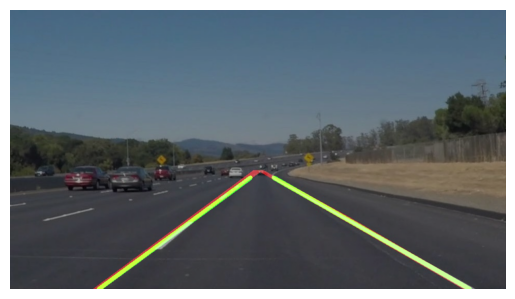

In [9]:
#Image Processing
from matplotlib import pyplot as plt
import os

input_img = r"C:\PERSONAL\Bala\Bala_MTECH\3 rd sem\Internship\SelfDriving\Input Images\solidWhiteCurve.jpg"
output_img = r"C:\PERSONAL\Bala\Bala_MTECH\3 rd sem\Internship\SelfDriving\LaneDetection\Output.jpg"

img = cv2.imread(input_img)
result = pipeline(img)

os.makedirs(os.path.dirname(output_img), exist_ok=True)
cv2.imwrite(output_img, result)

print("Image saved at:", output_img)

plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [11]:
#Video Processing
def process_video(input_video, output_video):
    cap = cv2.VideoCapture(input_video)

    if not cap.isOpened():
        print("ERROR: Cannot open input video")
        return

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    fps = cap.get(cv2.CAP_PROP_FPS)
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    os.makedirs(os.path.dirname(output_video), exist_ok=True)
    out = cv2.VideoWriter(output_video, fourcc, fps, (w,h))

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Apply your lane detection pipeline
        result = pipeline(frame)

        out.write(result)
        frame_count += 1

    cap.release()
    out.release()

    print(f"DONE — Saved: {output_video}")
    print(f"Frames Processed: {frame_count}")

input_video = r"C:\PERSONAL\Bala\Bala_MTECH\3 rd sem\Internship\SelfDriving\Input Video\solidWhiteRight.mp4"
output_video = r"C:\PERSONAL\Bala\Bala_MTECH\3 rd sem\Internship\SelfDriving\LaneDetection\Output"

process_video(input_video, output_video)

DONE — Saved: C:\PERSONAL\Bala\Bala_MTECH\3 rd sem\Internship\SelfDriving\LaneDetection\Output
Frames Processed: 221
